### загрузка данных

In [791]:
# pip install xlrd     # for reading excel files
# pip install openpyxl # for reading excel files
# !pip install pysrt

In [792]:
import pandas as pd
import numpy as np
import pysrt
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Дерево (стуктура) из каталогов и файлов, полученных от заказчика изначально <font color='grey'>(сформировано в командной строке GitBash)</font>:

<div style="border:solid Chocolate 2px; padding: 40px">

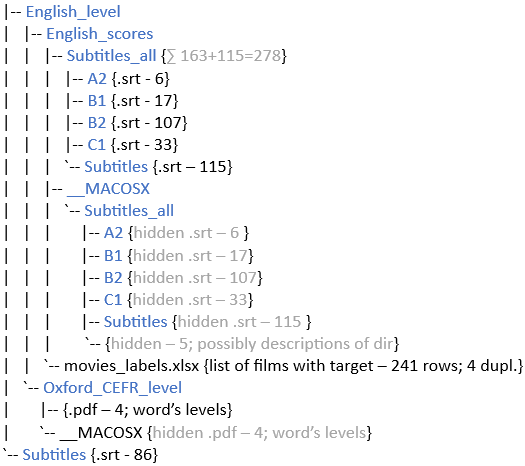

План работы:
* сопоставить все данные сущности: субтитры классифицированные (Subtitles_all), субтитры неклассифицированные (Subtitles),  перечень классифицированных названий субтитров (movies_labels.xlsx);\
в итоге необходим набор классифицированных субтитров без дубликатов; если останутся неклассифицированные субтитры, найти их классификацию в интернете;
* субтитры могу быть классифицированы неоднозначным целевым признаком (двойным, тройным, включать загрязняющие символы); необходимо оставить только 1 признак; выбор признака сделать с помощью Oxford_CEFR_level;
* загрузить субтитры в Pandas с помощью библиотеки pysrt;
* перевести перечень классифицированных субтитров в цифровой формат с помощью BoW или TF-IDF;
* с помощью кросс-валидации обучить модель и оценить качество предсказания; протестировать несколько моделей - линейная, дерево, лес, бустинг; разобраться с мультиклассовым предсказанием (какие модели, библиотеки его поддерживают);

Дополнительная работа (при наличии времени):
* увеличить базу классифицированных субтитров за счёт данных из сети;
* селать микроприложение Streamlit.


Перечень субтитров, прописанный в дереве, сохранил в файлах txt.

In [793]:
# загрузка перечней субтитров в Pandas
subtitles = pd.read_table('subtitles.txt')
english_level_subtitles = pd.read_table('english_level_subtitles.txt')
subtitles_all_A2 = pd.read_table('subtitles_all_A2.txt')
subtitles_all_B1 = pd.read_table('subtitles_all_B1.txt')
subtitles_all_B2 = pd.read_table('subtitles_all_B2.txt')
subtitles_all_C1 = pd.read_table('subtitles_all_C1.txt')
movies_labels    = pd.read_excel('English_level/English_scores/movies_labels.xlsx').drop('id',axis=1)

In [794]:
subtitles.head(2)

,Movie
0,10_Cloverfield_lane(2016).srt
1,10_things_I_hate_about_you(1999).srt


In [795]:
english_level_subtitles.head(2)

,Movie
0,10_Cloverfield_lane(2016).srt
1,10_things_I_hate_about_you(1999).srt


In [796]:
subtitles_all_A2.head(2)

,Movie
0,The Walking Dead-S01E01-Days Gone Bye.English.srt
1,The Walking Dead-S01E02-Guts.English.srt


In [797]:
movies_labels.head(2)

,Movie,Level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1


In [798]:
# новые столбцы в перечнях для идентификации после объединения перечней
subtitles['subtitles']=1
english_level_subtitles['el_subtitles']=1
subtitles_all_A2['subtitles_all']='A2'
subtitles_all_B1['subtitles_all']='B1'
subtitles_all_B2['subtitles_all']='B2'
subtitles_all_C1['subtitles_all']='C1'
subtitles_all = pd.concat((subtitles_all_A2,subtitles_all_B1,subtitles_all_B2,subtitles_all_C1))

In [799]:
# удаляем расширение .srt в трёх датасетах
for df in (subtitles,english_level_subtitles,subtitles_all):
    df['Movie']=df['Movie'].apply(lambda x: x[:-4])

In [800]:
# число полных дубликатов во всех четырёх датасетах
for df in (subtitles, 
           english_level_subtitles, 
           movies_labels, 
           subtitles_all):
    print(df.duplicated().sum())

0
0
2
0


In [801]:
# задублированные фильмы в 'movies_labels' 
movies_labels[movies_labels.duplicated(keep=False)]

,Movie,Level
38,Powder(1995),B1
43,Inside_out(2015),B1
44,Inside_out(2015),B1
68,Powder(1995),B1


In [802]:
# удаление полных дубликатов 
movies_labels = movies_labels.drop_duplicates()

In [803]:
# число дубликатов по признаку Movie в четырёх датасетах
for df in (subtitles, 
           english_level_subtitles, 
           movies_labels, 
           subtitles_all):
    print(df['Movie'].duplicated().sum())

0
0
2
0


In [804]:
# задублированные фильмы 'movies_labels' 
movies_labels[movies_labels['Movie'].duplicated(keep=False)]

,Movie,Level
75,The_blind_side(2009),B2
83,The_terminal(2004),B1
84,The_blind_side(2009),B1
99,The_terminal(2004),"A2/A2+, B1"


Объединим значения уровня у одинаковых фильмов. Лишние строки удалим.

In [805]:
movies_labels.loc[75,'Level'] = 'B1,B2'
movies_labels.drop([83,84], inplace=True)

In [806]:
# названия фильмов делаем индексами во всех датасетах
for df in (subtitles, 
           english_level_subtitles, 
           subtitles_all,
           movies_labels):
    df.set_index('Movie', inplace=True)

In [807]:
movies_labels.columns=['movies_labels']

In [808]:
# сводная со всеми упомянутыми в исходных данных фильмами
subtitles_pivot = subtitles.join(english_level_subtitles, how='outer')\
                           .join(subtitles_all,           how='outer')\
                           .join(movies_labels,           how='outer')

In [809]:
subtitles_pivot.head(3)

,subtitles,el_subtitles,subtitles_all,movies_labels
Movie,,,,
10_Cloverfield_lane(2016),1.0,1.0,NaN,B1
10_things_I_hate_about_you(1999),1.0,1.0,NaN,B1
A_knights_tale(2001),1.0,1.0,NaN,B2


In [810]:
subtitles_pivot.shape[0]

287

In [811]:
subtitles_pivot.count() # проверка кол-ва фильмов в каждом датасете

subtitles         86
el_subtitles     115
subtitles_all    163
movies_labels    237
dtype: int64

Всё соответсвует (с учётом четырёх убранных дубликатов).

### анализ сводной таблицы

Проверка на неявные дубликаты:

In [812]:
np.sort(subtitles_pivot.index.values)

array(['10_Cloverfield_lane(2016)', '10_things_I_hate_about_you(1999)',
       'A_knights_tale(2001)', 'A_star_is_born(2018)', 'Aladdin(1992)',
       'All_dogs_go_to_heaven(1989)', 'AmericanBeauty1999.BRRip',
       'An_American_tail(1986)', "Angela's.Christmas.2018.WEBRip.Netflix",
       'Angelas.Christmas.Wish.2020', 'Babe(1995)',
       'Back_to_the_future(1985)', 'Banking_On_Bitcoin(2016)',
       'Batman_begins(2005)', 'Beauty_and_the_beast(2017)',
       'Before_I_go_to_sleep(2014)', 'Before_sunrise(1995)',
       'Before_sunset(2004)', 'Braveheart(1995)',
       'Breaking_Bad_The_Movie(2017)',
       'Bren▒.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix',
       'Bridget_Jones_diary(2001)', 'Bridget_Joness_Baby', 'Bullet train',
       'Cars(2006)', 'Casper', 'Cast_away(2000)',
       'Catch_me_if_you_can(2002)', 'Charlie_and_the_Chocolate_Factory',
       'Cinderella(1950)', 'Clueless(1995)',
       'Collateral.Beauty.2016.720p.BRRip.x264.AAC-ETRG',
       '

В фильме 'Bren▒.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix' сбой кодировки в 5-ом символе из-за того, что в названии файла этот символ прописан кирилицей "В".\
Заменим название на идентичное файловому:

In [813]:
english_level_subtitles.rename(index={'Bren▒.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix':
                                      'BrenВ.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix'}, inplace=True)

In [814]:
# серии 'Crown'
subtitles_pivot.filter(regex='^Crown.*',axis=0)

,subtitles,el_subtitles,subtitles_all,movies_labels
Movie,,,,
"Crown, The S01E01 - Wolferton Splash.en",NaN,NaN,B2,NaN
"Crown, The S01E01 - Wolferton Splash.en.SDH",NaN,NaN,B2,NaN
"Crown, The S01E02 - Hyde Park Corner.en",NaN,NaN,B2,NaN
"Crown, The S01E02 - Hyde Park Corner.en.SDH",NaN,NaN,B2,NaN
"Crown, The S01E03 - Windsor.en",NaN,NaN,B2,NaN
"Crown, The S01E03 - Windsor.en.FORCED",NaN,NaN,B2,NaN
"Crown, The S01E03 - Windsor.en.SDH",NaN,NaN,B2,NaN
"Crown, The S01E04 - Act of God.en",NaN,NaN,B2,NaN
"Crown, The S01E04 - Act of God.en.SDH",NaN,NaN,B2,NaN


In [815]:
# в исходной таблице subtitles_all в сериях Crown удаляем дубликаты с SDH и FORCED
subtitles_all.drop(index=subtitles_pivot.filter(regex='^Crown.*(SDH|FORCED)$',axis=0).index, inplace=True)

In [816]:
# дубликаты 'Its_a_wonderful_life(1946)'
subtitles_pivot.filter(items=['It_s_a_wonderful_life(1946)',
                              'Its_a_wonderful_life(1946)'],axis=0)

,subtitles,el_subtitles,subtitles_all,movies_labels
Movie,,,,
It_s_a_wonderful_life(1946),1.0,NaN,NaN,NaN
Its_a_wonderful_life(1946),NaN,1.0,NaN,A2/A2+


In [817]:
# в исходной таблице 'subtitles' исправление названия
subtitles.rename(index={'It_s_a_wonderful_life(1946)':'Its_a_wonderful_life(1946)'}, inplace=True)

In [818]:
# дубликаты с 'Up'
subtitles_pivot.filter(items=['Up (2009)', 'Up(2009)'] ,axis=0)

,subtitles,el_subtitles,subtitles_all,movies_labels
Movie,,,,
Up (2009),NaN,NaN,NaN,A2/A2+
Up(2009),1.0,1.0,NaN,NaN


In [819]:
# в исходной таблице 'movies_labels' исправление названия
movies_labels.rename(index={'Up (2009)':'Up(2009)'}, inplace=True)

In [820]:
# сводная со всеми упомянутыми в проекте фильмами (после удаления дубликатов)
subtitles_pivot = subtitles.join(english_level_subtitles, how='outer')\
                           .join(subtitles_all,           how='outer')\
                           .join(movies_labels,           how='outer')

**'subtitles' и 'el_subtitles', cравнение**

In [821]:
# кол-во различных позиций в 'subtitles' и 'el_subtitles'
subtitles_pivot.query('(subtitles.isna() & ~el_subtitles.isna()) | (~subtitles.isna() & el_subtitles.isna())').shape[0]

29

Видим разницу:\
'el_subtitles' (115) - 'subtitles' (86) = (29)\
В 'el_subtitles' все фильмы из 'subtitles' (86 шт.), а также дополнительно ещё 29 уникальных.\
В работе необходимо использовать 'el_subtitles', как более обширную базу и включающую в себя маленькую базу  'subtitles'.

Таким образом, остаётся 3 столбца (базы данных) для работы:

In [822]:
subtitles_pivot.drop('subtitles', axis=1, inplace=True) # удаляем лишний столбец
subtitles_pivot.head()

,el_subtitles,subtitles_all,movies_labels
Movie,,,
10_Cloverfield_lane(2016),1.0,NaN,B1
10_things_I_hate_about_you(1999),1.0,NaN,B1
A_knights_tale(2001),1.0,NaN,B2
A_star_is_born(2018),1.0,NaN,B2
Aladdin(1992),1.0,NaN,A2/A2+


Рабочий датасет собираем из пересечения непустых множеств: 'subtitles_all' и комбинация 'el_subtitles' с 'movies_labels'.

Напоминание:
* 'subtitles_all' - есть и субтитры и целевой признак;
* 'el_subtitles' - только субтитры без целевого признака;
* 'movies_labels' - перечень названий субтитров с целевым признаком;

In [823]:
# число фильмов, которые можно использовать в исходном датасете
subtitles_pivot.query('~subtitles_all.isna() | (~el_subtitles.isna() & ~movies_labels.isna())').shape[0]

256

Проверка нет ли разных значений целевого признака в 'subtitles_all' и 'movies_labels':

In [824]:
# число фильмов, которые присутствуют в базах subtitles_all и movies_labels; их значения уровня английского отличаются
subtitles_pivot.query('subtitles_all!=movies_labels & ~subtitles_all.isna() & ~movies_labels.isna()').shape[0]

0

Противоречий нет.

In [825]:
# фильмы, которые нельзя использовать в исходном датасете из-за отсутствия либо субтитров, либо целевого признака
subtitles_pivot.query('~(~subtitles_all.isna() | (~el_subtitles.isna() & ~movies_labels.isna()))')

,el_subtitles,subtitles_all,movies_labels
Movie,,,
Breaking_Bad_The_Movie(2017),1.0,NaN,NaN
BrenВ.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix,1.0,NaN,NaN
Bullet train,NaN,NaN,B1
Casper,1.0,NaN,NaN
Glass Onion,NaN,NaN,B2
Gogo_Loves_English,1.0,NaN,NaN
Harry_Potter_and_the_philosophers_stone(2001),1.0,NaN,NaN
Lightyear,NaN,NaN,B2
Matilda(2022),NaN,NaN,C1


Фильмы в количестве 15 шт. не могут быть использованы.

Нашёл в интернет субтитры для следующих фильмов: Bullet train, Lightyear, The Grinch, The Secret Life of Pets.en, Thor love and thunder.\
Целевой признак содержится в movie_labels.

In [826]:
# в сводной таблице в 'Thor: love and thunder' уберём двоеточие
subtitles_pivot.rename(index={'Thor: love and thunder':'Thor love and thunder'}, inplace=True)

In [827]:
# в сводной таблице присвоим 1 в el_subtitles фильмам с найденными субтитрами
for i in ('Bullet train', 'Lightyear', 'The Grinch', 'The Secret Life of Pets.en', 'Thor love and thunder'):
    subtitles_pivot.loc[i,'el_subtitles'] = 1

In [828]:
# число фильмов, которые нельзя использовать в исходном датасете из-за отсутствия либо субтитров, либо целевого признака
subtitles_pivot.query('~(~subtitles_all.isna() | (~el_subtitles.isna() & ~movies_labels.isna()))').shape[0]

10

In [829]:
# число фильмов, которые можно использовать в исходном датасете (после добавления найденных в интернет субтитров)
subtitles_pivot.query('~subtitles_all.isna() | (~el_subtitles.isna() & ~movies_labels.isna())').shape[0]

261

Таким образом мы определили перечень фильмов для последующей работы с ML.

### создание исходной базы данных

Загружаем субтитры со всех каталогов согласно сформированному выше перечню фильмов.\
Большинство субтитров загружается с кодировкой по умолчанию "UTF-8". Также есть около десятка файлов, которые могут быть загружены только с кодировкой "iso-8859-1".

In [830]:
for catalog in (
    'English_level/English_scores/Subtitles_all/Subtitles/',
    'English_level/English_scores/Subtitles_all/A2/',
    'English_level/English_scores/Subtitles_all/B1/',
    'English_level/English_scores/Subtitles_all/B2/',
    'English_level/English_scores/Subtitles_all/C1/',
    'Subtitles Extra/'):
    for film in subtitles_pivot.index:
        try:
            subtitles_pivot.loc[film, 'subtitles'] = pysrt.open(catalog+film+'.srt').text
        except:
            try:
                subtitles_pivot.loc[film, 'subtitles'] = pysrt.open(catalog+film+'.srt', encoding='iso-8859-1').text
            except:
                pass

In [831]:
subtitles_pivot

,el_subtitles,subtitles_all,movies_labels,subtitles
Movie,,,,
10_Cloverfield_lane(2016),1.0,NaN,B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),1.0,NaN,B1,"Hey!\nI'll be right with you.\nSo, Cameron. He..."
A_knights_tale(2001),1.0,NaN,B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...
A_star_is_born(2018),1.0,NaN,B2,"- <i><font color=""#ffffff""> Synced and correct..."
Aladdin(1992),1.0,NaN,A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac..."
...,...,...,...,...
While_You_Were_Sleeping(1995),1.0,NaN,B1,"LUCY: <i>Okay, there are two things that</i>\n..."
Zootopia(2016),1.0,NaN,B2,Fear. Treachery Bloodlust.\nThousands of years...
icarus.2017.web.x264-strife,NaN,B2,NaN,Line drive to right field...\nSolemnly swear t...


In [832]:
# число фильмов, которые можно использовать в исходном датасете (после добавления найденных в интернет субтитров) и
# ...после добавления нового признака с субтитрами
subtitles_pivot.query('(~subtitles_all.isna() | (~el_subtitles.isna() & ~movies_labels.isna())) & ~subtitles.isna()').shape[0]

261

Количество идентичное прогнозируемому ранее. Создание нового признака с субтитрами прошло без ошибок.

In [833]:
# целевой признак из двух столбцов 'subtitles_all', 'movies_labels' объединим в 1 'movies_labels'
subtitles_pivot.loc[subtitles_pivot['movies_labels'].isna(), 'movies_labels'] = \
subtitles_pivot.loc[subtitles_pivot['movies_labels'].isna(), 'subtitles_all']

# удаление лишних столбцов
subtitles_pivot.drop(['el_subtitles','subtitles_all'], axis=1, inplace=True)

# удаление объектов с пропусками (не известны либо субтитры, либо уровень английского)
subtitles_pivot.dropna(inplace=True)

In [834]:
subtitles_pivot.shape # размер датасета для последующего ML

(261, 2)

In [835]:
subtitles_pivot.head() # топ-5 позиций полученного датасета

,movies_labels,subtitles
Movie,,
10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He..."
A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...
A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct..."
Aladdin(1992),A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac..."


### Предварительная обработка текста

In [836]:
def preprocessing(X):
    '''удаляет спец. и одиночные символы, цифры, дубли, стоп-слова; стемминг (или лемматизация); на входе/выходе Series'''
    documents = []
    stemmer = WordNetLemmatizer()
    porter = PorterStemmer()
    stop = stopwords.words('english')+['br', 'mr', 'mrs', 'miss', 'ms', 'bozxphd', 'â', 'ª', 'ªâ', 'âª']
    
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))   
        
        # remove all numbers
        document = re.sub(r'\d', ' ', document)
        
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+([a-zA-Z]\s+)*', ' ', document)
        
        # remove all duplicate characters
        document = re.sub(r'\s+([a-zA-Z])\1+\s+(([a-zA-Z])\1+\s+)*', ' ', document)
        
        # Remove single characters from the start and at the end
        document = re.sub(r'^[a-zA-Z]\s+|\s+[a-zA-Z]$', ' ', document)
        
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document)
        
        # Converting to Lowercase
        document = document.lower()
        
        # Lemmatization or/and Stemming
        document = document.split()
        
        # document = [stemmer.lemmatize(word) for word in document]
        document = [porter.stem(word) for word in document] # выбираю стемминг, т.к. даёт меньше вариаций слова
        
        # delete stopwords
        document = [word for word in document if word not in stop]
        
        document = ' '.join(document)
                
        documents.append(document)
        
    return pd.Series(documents, X.index)

In [837]:
# предобработка субтитров
subtitles_pivot['subtitles'] = preprocessing(subtitles_pivot['subtitles'])

In [838]:
subtitles_pivot['movies_labels'].value_counts() # уникальные значения CEFR-уровней

B2            124
B1             52
C1             39
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
B1,B2           1
Name: movies_labels, dtype: int64

Для ML двоякого толкования быть не должно. Значения с "+" уберём.\
При нескольких уровнях, укажем наивысшей, так как более высокий уровень включает в себя более низкие.

In [839]:
subtitles_pivot['movies_labels'].replace({'A2/A2+'    : 'A2', 
                                          'B1, B2'    : 'B2', 
                                          'B1,B2'     : 'B2', 
                                          'A2/A2+, B1': 'B1'}, inplace=True)

In [840]:
subtitles_pivot.head() # топ-5 позиций полученного датасета

,movies_labels,subtitles
Movie,,
10_Cloverfield_lane(2016),B1,font color fix sync enjoy flick font clang dra...
10_things_I_hate_about_you(1999),B1,hey right cameron go nine school year armi bra...
A_knights_tale(2001),B2,resync xenzai nef retail help due list two min...
A_star_is_born(2018),B2,font color sync correct font font color ffd mr...
Aladdin(1992),A2,oh come land faraway place caravan camel roam ...


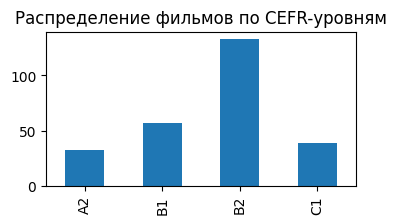

In [841]:
subtitles_pivot['movies_labels'].value_counts().sort_index().plot(kind='bar', figsize=(4,2), 
                                                                  title='Распределение фильмов по CEFR-уровням'); plt.show()

#### Oxford vocabulary preprocessing

In [842]:
# общий словарный df
ox_vocabulary = pd.DataFrame(index=['American_Oxford_3000_by_CEFR_level_A1',
                                    'American_Oxford_3000_by_CEFR_level_A2',
                                    'American_Oxford_3000_by_CEFR_level_B1',
                                    'American_Oxford_3000_by_CEFR_level_B2',
                                    'American_Oxford_5000_by_CEFR_level_B2',
                                    'American_Oxford_5000_by_CEFR_level_C1',
                                    'The_Oxford_3000_by_CEFR_level_A1',
                                    'The_Oxford_3000_by_CEFR_level_A2',
                                    'The_Oxford_3000_by_CEFR_level_B1',
                                    'The_Oxford_3000_by_CEFR_level_B2',
                                    'The_Oxford_5000_by_CEFR_level_B2',
                                    'The_Oxford_5000_by_CEFR_level_C1'], 
                             columns=['words'])                                 

In [843]:
# создаём 12 df'ов соответствующих словарям
for i in ox_vocabulary.index:
    exec(i + "= pd.read_table('Oxford_SEFR_level/'+i+'.txt', names=['word'])")

In [844]:
American_Oxford_3000_by_CEFR_level_A1.head() # пример вида одного из словарей

,word
0,"a, an indefinite article"
1,"about prep., adv."
2,"above prep., adv."
3,"across prep., adv."
4,action n.


In [845]:
# в словарях оставляем только слова, без уточнений части речи
for i in ox_vocabulary.index:
        globals()[i]['word'] =\
        globals()[i]['word'].apply(lambda x: re.match('[a-zA-Z]+',x).group())

# в сводную словарную таблицу вносим соответствующие слова
        ox_vocabulary.loc[i,'words'] = ' '.join(globals()[i]['word'].values)

In [846]:
# сводную словарную таблицу обрабатываем по тому же стандарту, что и субтитры (стемминг, нижн.регистр, стоп-слова)
ox_vocabulary['words'] = preprocessing(ox_vocabulary['words'])

In [847]:
ox_vocabulary

,words
American_Oxford_3000_by_CEFR_level_A1,abov across action activ actor actress add add...
American_Oxford_3000_by_CEFR_level_A2,abil abl accept accid accord achiev act activ ...
American_Oxford_3000_by_CEFR_level_B1,absolut academ access account achiev act ad ad...
American_Oxford_3000_by_CEFR_level_B2,abandon abroad absolut accept accompani accoun...
American_Oxford_5000_by_CEFR_level_B2,absorb abstract accent accident accommod accom...
American_Oxford_5000_by_CEFR_level_C1,abolish abort absenc absent absurd abus academ...
The_Oxford_3000_by_CEFR_level_A1,abov across action activ actor actress add add...
The_Oxford_3000_by_CEFR_level_A2,abil abl abroad accept accid accord achiev act...
The_Oxford_3000_by_CEFR_level_B1,absolut academ access accommod account achiev ...
The_Oxford_3000_by_CEFR_level_B2,abandon absolut academ accept accompani accoun...


Объединим все 12 словарей в 5 базовых: A1, A2, B1, B2, C1.

In [848]:
# новый сжатый словарь
ox_vocabulary_short = pd.Series(index=['A1', 'A2', 'B1', 'B2', 'C1'], dtype='object')

In [849]:
# столбец 'words' переводим в формат множества
ox_vocabulary['words']=\
ox_vocabulary['words'].apply(lambda x: set(x.split()))

In [850]:
# фильтруем 'ox_vocabulary' по уровню CEFR; строки по одному уровню объединяем, как множества 
for i in ox_vocabulary_short.index:
    ox_vocabulary_short.loc[i] = ' '.join(reduce(lambda x,y: set(x)|set(y), 
                                                 ox_vocabulary.filter(like=i,axis=0)['words']))

In [851]:
ox_vocabulary_short

A1    histori delici custom anyon key supermarket da...
A2    avoid cover fresh industri clearli thought arr...
B1    attitud cover tube mysteri custom key file mus...
B2    mysteri thorough forecast industri stall draft...
C1    republ thought copyright disclosur confin none...
dtype: object

### Machine learning

#### Splitting and coding

In [852]:
# замена строчного обозначения CEFR-уровня на числовое
subtitles_pivot['movies_labels'].replace({'A1':0, 'A2':1, 'B1':2, 'B2':3, 'C1':4}, inplace=True)

In [853]:
# разбиение исходной табицы с субтитрами на признаки и целевые признаки
features = subtitles_pivot['subtitles']
target   = subtitles_pivot['movies_labels']

# разбиение признаков на обучающие и тестовые (75/25)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            stratify=target, random_state=12345)

In [854]:
# размеры полученных выборок
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(195,) (195,)
(66,) (66,)


**Bag-of-words**

In [855]:
count = CountVectorizer()
count.fit(features_train)
bag_train = count.transform(features_train).toarray()
bag_test  = count.transform(features_test).toarray()

In [856]:
bag_train # общий вид множества

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [857]:
# размеры множеств для обучения и теста
print(bag_train.shape)
print(bag_test.shape)

(195, 19884)
(66, 19884)


**TF-IDF**

In [858]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
tfidf.fit(bag_train)
features_train_tfidf = tfidf.transform(bag_train).toarray()
features_test_tfidf  = tfidf.transform(bag_test).toarray()

In [859]:
features_train_tfidf # общий вид множества

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.0090951,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [860]:
# размеры множеств для обучения и теста
print(features_train_tfidf.shape)
print(features_test_tfidf.shape)

(195, 19884)
(66, 19884)


#### Oxford vocabulary prediction

In [861]:
class OxfordVocabulary:
    '''прогнозирует CEFR-уровень текста {0:A1, 1:A2, 2:B1, 3:B2, 4:C1} на основании кол-ва слов соответствующих определённому
    уровню; гиперпараметр для подбора лучшего предсказания - доля сложных слов (сумма долей уровней от С1 к А1); при 
    инициализации класса передать Series-словарь (индексы = [A1, A2, B1, B2, C1]); набор текстов для определения уровня 
    передаётся в виде Series через метод word_count; данные в словаре/наборе текстов в строчном формате и должны быть 
    обработаны по одному стандарту - стемминг и/или др.; доля сложных слов передаётся в метод predict; на выходе Series'''

    def __init__(self, vocabulary):
        self.vocabulary = vocabulary.apply(lambda x: x.split())
        
    def word_count(self, subtitles):
        self.subtitles_word_count = subtitles.apply(lambda x: x.split())\
                                             .apply(lambda x: self.counter(x))
        self.subtitles_word_share = self.subtitles_word_count\
                                             .apply(lambda x: (x/sum(x)).round(3))
        self.subtitles_word_share_cumulative = self.subtitles_word_share\
                                             .apply(lambda x: (np.array([sum(x), sum(x[1:]), sum(x[2:]), 
                                                                         sum(x[3:]), x[4]]).round(3)))
        
    def predict(self, share_of_difficult_words):
        subtitles_word_share_cumulative_with_barrier =\
        self.subtitles_word_share_cumulative.apply(lambda x: sorted(np.append(x, share_of_difficult_words).tolist(), 
                                                                    reverse=True))
        return subtitles_word_share_cumulative_with_barrier\
                                             .apply(lambda x: min(x.index(share_of_difficult_words), 4))
    
    def counter(self, subtitle):
        A1,A2,B1,B2,C1 = 0,0,0,0,0
        for i in subtitle:
            if   i in self.vocabulary['A1']:
                A1+=1
            elif i in self.vocabulary['A2']:
                A2+=1
            elif i in self.vocabulary['B1']:
                B1+=1
            elif i in self.vocabulary['B2']:
                B2+=1
            elif i in self.vocabulary['C1']:
                C1+=1
        return np.array([A1,A2,B1,B2,C1])

In [862]:
model = OxfordVocabulary(ox_vocabulary_short) # создаём структуру данных, в которую сохраняем словарь

In [863]:
%%time
model.word_count(features_train) # расчёт долей кол-ва слов по CEFR-уровням в каждом фильме

CPU times: total: 23.3 s
Wall time: 23.3 s


In [864]:
# расчёт accuracy в зависимости от гиперпараметра "доля сложных слов"
result = pd.Series(dtype='float64')
for share_of_difficult_words in np.arange(0,1.001,0.001):
    result = pd.concat([result, pd.Series(accuracy_score(target_train, model.predict(share_of_difficult_words)), 
                                          index=[share_of_difficult_words])])   

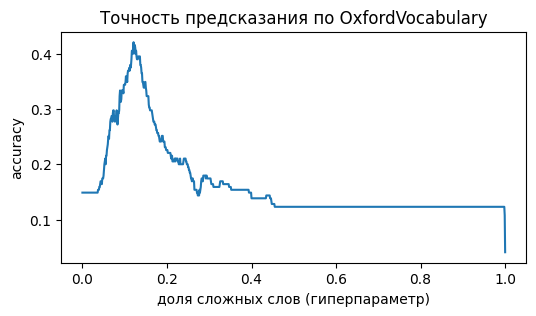

Accuracy_max = 0.421   при   share_of_difficult_words = 0.121


In [865]:
result.plot(xlabel='доля сложных слов (гиперпараметр)', ylabel='accuracy', 
            title='Точность предсказания по OxfordVocabulary', figsize=(6,3)); plt.show()
print(f"Accuracy_max = {result.max():.3f}   при   share_of_difficult_words = {result.idxmax()}")

#### Logistic regression

In [866]:
%%time
model = LogisticRegression()
parametrs = {'solver': ('lbfgs', 'newton-cg', 'saga'), 
             'max_iter': (100, 1000),
             'class_weight': (None, 'balanced'),
             'random_state': [12345], 
             'multi_class': ['multinomial']}
grid_lr = GridSearchCV(estimator = model, param_grid = parametrs)
grid_lr.fit(features_train_tfidf, target_train)

CPU times: total: 1min 24s
Wall time: 46.7 s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': (None, 'balanced'),
                         'max_iter': (100, 1000),
                         'multi_class': ['multinomial'],
                         'random_state': [12345],
                         'solver': ('lbfgs', 'newton-cg', 'saga')})

In [867]:
# best accuracy
round(grid_lr.best_score_, 3)

0.579

In [868]:
# hyperparameters for best accuracy
pd.DataFrame(grid_lr.cv_results_).sort_values(by='rank_test_score')['params'].reset_index(drop=True)[0] 

{'class_weight': 'balanced',
 'max_iter': 100,
 'multi_class': 'multinomial',
 'random_state': 12345,
 'solver': 'lbfgs'}

#### DecisionTreeClassifier

In [869]:
%%time
model = DecisionTreeClassifier()
parametrs = {'max_depth': range (3,21),
             'criterion': ('gini', 'entropy', 'log_loss'),
             'min_samples_split': (2,3,4),
             'min_samples_leaf': (1,2,3),
             'class_weight': (None, 'balanced'),
             'random_state': [12345]}

grid_dtc = RandomizedSearchCV(estimator = model, param_distributions = parametrs, random_state = 123, n_iter=60)
grid_dtc.fit(features_train_tfidf, target_train)

CPU times: total: 56.3 s
Wall time: 56.3 s


RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=60,
                   param_distributions={'class_weight': (None, 'balanced'),
                                        'criterion': ('gini', 'entropy',
                                                      'log_loss'),
                                        'max_depth': range(3, 21),
                                        'min_samples_leaf': (1, 2, 3),
                                        'min_samples_split': (2, 3, 4),
                                        'random_state': [12345]},
                   random_state=123)

In [870]:
# топ-10 лучших вариантов по гиперпараметрам
important_metrics = ['rank_test_score','mean_test_score','param_min_samples_split', 'param_min_samples_leaf', 
                     'param_max_depth', 'param_criterion', 'param_class_weight']

pd.DataFrame(grid_dtc.cv_results_)[important_metrics].sort_values(by = 'rank_test_score').set_index('rank_test_score').head(10)

,mean_test_score,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_class_weight
rank_test_score,,,,,,
1,0.589744,3,1,19,gini,None
2,0.574359,2,2,19,gini,None
2,0.574359,3,2,12,gini,None
4,0.569231,3,3,3,gini,None
5,0.564103,3,3,7,gini,None
6,0.548718,4,3,17,gini,None
6,0.548718,4,3,20,gini,None
8,0.517949,4,2,4,log_loss,None
9,0.512821,3,3,8,log_loss,None


In [871]:
# best accuracy
round(grid_dtc.best_score_, 3)

0.59

Cузим окно возможных гиперпараметров:

In [872]:
%%time
parametrs = {'max_depth': range (15,25),
             'criterion': ['gini'],
             'min_samples_split': (2,3),
             'min_samples_leaf': (1,2),
             'class_weight': [None],
             'random_state': [12345]}
grid_dtc = GridSearchCV(estimator = model, param_grid = parametrs)
grid_dtc.fit(features_train_tfidf, target_train)

CPU times: total: 31.5 s
Wall time: 31.5 s


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None], 'criterion': ['gini'],
                         'max_depth': range(15, 25), 'min_samples_leaf': (1, 2),
                         'min_samples_split': (2, 3), 'random_state': [12345]})

In [873]:
# best accuracy
round(grid_dtc.best_score_, 3)

0.59

In [874]:
# hyperparameters for best accuracy
pd.DataFrame(grid_dtc.cv_results_).sort_values(by='rank_test_score')['params'].reset_index(drop=True)[0] 

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 21,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'random_state': 12345}

#### RandomForestClassifier

In [875]:
%%time
model = RandomForestClassifier()
parametrs = {'max_depth': range (3,21),
             'n_estimators': range (20,201,20),
             'criterion': ('gini', 'entropy', 'log_loss'),
             'min_samples_split': (2,3,4),
             'min_samples_leaf': (1,2,3),
             'class_weight': (None, 'balanced'),
             'random_state': [12345]}

grid_rfc = RandomizedSearchCV(estimator = model, param_distributions = parametrs, random_state = 123, n_iter=40)
grid_rfc.fit(features_train_tfidf, target_train)

CPU times: total: 1min 1s
Wall time: 1min 1s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=40,
                   param_distributions={'class_weight': (None, 'balanced'),
                                        'criterion': ('gini', 'entropy',
                                                      'log_loss'),
                                        'max_depth': range(3, 21),
                                        'min_samples_leaf': (1, 2, 3),
                                        'min_samples_split': (2, 3, 4),
                                        'n_estimators': range(20, 201, 20),
                                        'random_state': [12345]},
                   random_state=123)

In [876]:
# топ-10 лучших вариантов по гиперпараметрам
important_metrics = ['rank_test_score','mean_test_score','param_min_samples_split', 'param_min_samples_leaf', 
                     'param_max_depth', 'param_n_estimators', 'param_criterion', 'param_class_weight']
pd.DataFrame(grid_rfc.cv_results_)[important_metrics].sort_values(by = 'rank_test_score').set_index('rank_test_score').head(10)

,mean_test_score,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_n_estimators,param_criterion,param_class_weight
rank_test_score,,,,,,,
1,0.579487,4,3,11,100,gini,balanced
2,0.574359,2,2,6,60,entropy,balanced
3,0.569231,4,3,16,80,gini,balanced
3,0.569231,4,2,13,120,log_loss,None
3,0.569231,3,2,13,60,gini,None
6,0.564103,3,1,15,60,gini,None
6,0.564103,2,2,18,60,gini,None
6,0.564103,3,2,16,160,gini,balanced
6,0.564103,3,2,18,160,gini,balanced


In [877]:
# best accuracy
round(grid_rfc.best_score_, 3)

0.579

Cузим окно возможных гиперпараметров:

In [878]:
%%time
model = RandomForestClassifier()
parametrs = {'max_depth': range (5,18),
             'n_estimators': range (60,181,20),
             'criterion': ('gini', 'entropy'),
             'min_samples_split': (2,4),
             'min_samples_leaf': (2,3),
             'class_weight': ['balanced'],
             'random_state': [12345]}

grid_rfc = RandomizedSearchCV(estimator = model, param_distributions = parametrs, random_state = 123, n_iter=40)
grid_rfc.fit(features_train_tfidf, target_train)

CPU times: total: 59.1 s
Wall time: 59.2 s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=40,
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ('gini', 'entropy'),
                                        'max_depth': range(5, 18),
                                        'min_samples_leaf': (2, 3),
                                        'min_samples_split': (2, 4),
                                        'n_estimators': range(60, 181, 20),
                                        'random_state': [12345]},
                   random_state=123)

In [879]:
# топ-10 лучших вариантов по гиперпараметрам
pd.DataFrame(grid_rfc.cv_results_)[important_metrics].sort_values(by = 'rank_test_score').set_index('rank_test_score').head(10)

,mean_test_score,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_n_estimators,param_criterion,param_class_weight
rank_test_score,,,,,,,
1,0.600000,2,3,11,80,gini,balanced
2,0.589744,4,2,17,100,gini,balanced
3,0.584615,2,2,13,180,gini,balanced
3,0.584615,2,3,12,160,entropy,balanced
5,0.579487,4,2,12,60,gini,balanced
6,0.574359,4,3,11,120,gini,balanced
7,0.574359,4,2,6,60,entropy,balanced
7,0.574359,2,2,7,80,gini,balanced
7,0.574359,4,2,8,60,gini,balanced


In [880]:
# best accuracy
round(grid_rfc.best_score_, 3)

0.6

Cузим окно возможных гиперпараметров:

In [881]:
%%time
parametrs = {'max_depth': range (9,14),
             'n_estimators': range (70,101,10),
             'criterion': ['gini'],
             'min_samples_split': (2,4),
             'min_samples_leaf': (2,3),
             'class_weight': ['balanced'],
             'random_state': [12345]}
grid_rfc = GridSearchCV(estimator = model, param_grid = parametrs)
grid_rfc.fit(features_train_tfidf, target_train)

CPU times: total: 1min 26s
Wall time: 1min 26s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'criterion': ['gini'],
                         'max_depth': range(9, 14), 'min_samples_leaf': (2, 3),
                         'min_samples_split': (2, 4),
                         'n_estimators': range(70, 101, 10),
                         'random_state': [12345]})

In [882]:
# best accuracy
round(grid_rfc.best_score_, 3)

0.6

In [883]:
# hyperparameters for best accuracy
pd.DataFrame(grid_rfc.cv_results_).sort_values(by='rank_test_score')['params'].reset_index(drop=True)[0] 

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 12345}